# Welcome

In this notebook we are going to train our own [Deep Neural Network (DNN)](https://en.wikipedia.org/wiki/Deep_learning).

With our DNN we are going to be solving a [Categorical Classification](https://en.wikipedia.org/wiki/Statistical_classification) problem in the [Computer Vision](https://en.wikipedia.org/wiki/Computer_vision) domain.

This means that we will present an image of a face to our DNN and our DNN will predict whether this image is your face or a random other face.

This first step in training a DNN is making sure we have lots of high quality training data. Because collecting lots of images where the object/face is visible and lots of images where teh object/face is not visible is a lenghthy and boring task, we'll be using a couple of techniques to artifically boost our dataset.
* We will collect a small amout of images of your own face use augmentation techniques to generate more images images for the MATCH class.
* We will download a dataset with lots of images of faces. These images will serve as the NO-MATCH class.
* We will download a second dataset with lots of images of object, scenes and animals to act as the NO-FACE class.

To make training easier we will use a ready-made state-of-the-art architecture for image classification called [Xception](https://arxiv.org/abs/1610.02357).

Finally we will download the our DNN to our phones and run inference on a realtime camera feed using TensorFlowLite.


---


**Before we get started we will need to download the app to our phones**

iOS:
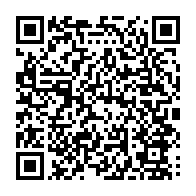
Android: 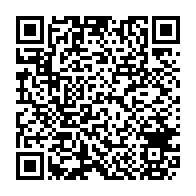


# Importing our libraries and frameworks

The first thing we need to do is import the libraries and frameworks that we are going to use.
* **Keras** -> High-level API to control TensorFlow (Deep Learning Library)
* **Matplotlib** -> Plotting library to visually inspect our input images
* **Augmentor** -> Used for augmenting the images in our dataset (uses PIL)
* **QRCode** -> Library for generating a QR-code


In [ ]:
!pip install qrcode Augmentor > /dev/null
import tensorflow as tf
import matplotlib.pyplot as plt
import os, zipfile, qrcode, math, base64, IPython, Augmentor, requests, glob, json
from PIL import Image

# Downloading NO-FACE and NO-MATCH images

The first thing we will do is download our reference images which we will use as the NO-FACE class. We are downloading the images from a publically available dataset called [Common Objects In Context (COCO)](https://cocodataset.org/#home). This dataset contains lots of images of everyday objects and scenes. Some of the images also contain people. We remove these images since they might confuse our DNN.

The NO-MATCH images we will download from the [Labeled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/) dataset. This dataset contains images of faces of different persons with different ethnicities and backgrounds.

In [ ]:
!rm -rf lfw val2017 data/no-face data/no-match val2017.zip lfw.tgz annotations_trainval2017.zip annotations
!mkdir data

!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip > /dev/null
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip > /dev/null

with open("annotations/person_keypoints_val2017.json", "r") as f:
  annotations = json.load(f)

for annotation in annotations["annotations"]:
  image_id = annotation["image_id"]
  file_name = next(x["file_name"] for x in annotations["images"] if x["id"] == image_id)
  if os.path.exists(f"val2017/{file_name}"):
    os.remove(f"val2017/{file_name}") 

!mv val2017 data/no-face

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar zxvf lfw.tgz > /dev/null

files = glob.glob(f"lfw/**/*.jpg")
os.mkdir("data/no-match")
amount = len(os.listdir("data/no-face"))
for file in files[:amount]:
  filename = os.path.basename(file)
  os.rename(file, f"data/no-match/{filename}")


# Adding and Augmenting our own images

The next step is to upload our own images. We need to take at least 25 pictures (the more the better) of our face. Getting good quality data is by far the most important step so feel free to take your time to take pictures in different locations with different lighting situations.

To upload these images we simply need to create a zip file called 'data.zip' and upload this file into Colab before running the next block.

We can upload files into Colab by clicking the files tab on the left and either dragging the zip file in or using the upload button. It takes a while to upload files into Colab, you can see the progress in the bottom left corner.

After the images are loaded into Colab, we need to digitally augment the images. We will create these augmented images by running our original images through an augmentation pipeline. In this pipeline random augmentations will be added. Using this pipeline we will create images that all look differently.

In [ ]:
!rm -rf original data/match
if not os.path.exists("data.zip"):
  raise Exception("Please upload a data.zip file containing your images")

with zipfile.ZipFile("data.zip", "r") as zip_obj:
  images = zip_obj.namelist()
  images = [ x for x in images if x.endswith(".jpg") or x.endswith(".png") ]
  images = [ x for x in images if not "__MACOSX" in x ]
  if len(images) < 25:
    raise Exception("Please make sure data.zip contains at least 25 images (jpg or png)")
  for image in images:
    zip_obj.extract(image, f"original")
    data = Image.open(f"original/{image}")
    data.thumbnail([512, 512], Image.LANCZOS)
    data.save(f"original/{image}", "JPEG")

amount = len(os.listdir("data/no-match"))
p = Augmentor.Pipeline("original", output_directory="../data/match")
p.random_distortion(probability=0.2, grid_width=4, grid_height=4, magnitude=8)
p.random_contrast(probability=0.2, min_factor=0.5, max_factor=1)
p.random_color(probability=0.2, min_factor=0.5, max_factor=1)
p.random_brightness(probability=0.2, min_factor=0.5, max_factor=1)
p.sample(amount)

# Creating our data loaders

While training, we are going to need to dynamically load the images that we are going to train on (because the whole dataset does not fit in memory in one go).

To do this we are going to use a Keras DataGenerator. This class will handle all the IO and preprocessing and batching for us. We are going to be working with batches of 128 images. This means we will train on 128 images at the same to to speed up te training process.

As you can see in the block below we are going to create two generators. The first generator contains the images that we are going to train our DNN on. The second generator contains our validation images. We will use the validation images to make sure our DNN is not overfitting. For this it is important that the training images and the validation images are kept strictly separate. The result on the validation images will give us an idea of how well our DNN can generalize to images it has never seen before.

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=360,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

print("Training data:")
train_gen = data_gen.flow_from_directory(
    "data",
    target_size=(224, 224),
    batch_size=32,
    subset="training"
)
print()

print("Validation data:")
val_gen = data_gen.flow_from_directory(
    "data",
    target_size=(224, 224),
    batch_size=32,
    subset="validation"
)

# Inspecting our input data

It is good practice to inspect our input data before we start training. This next block will show 25 images. Underneath each image we see the label of the class that this image belongs to.

These labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot). Which means that it is a list of integers of which only one is equal to '1'. The index of the '1' integer relates to the class this image belongs to. This means that if we see [1, 0, 0] this image belongs to the first class (MATCH), if we see [0, 1, 0] it belongs to the second class (NO-FACE) and if we see [0, 0, 1] this image belongs to the third class (NO-MATCH).

If there is something wrong with the way we load our input images we can instantly see it here.

In [ ]:
plt.figure(figsize=(10,10))
batch = train_gen.next()
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(batch[0][i], cmap=plt.cm.binary)
  plt.xlabel(batch[1][i])
plt.show()

# Creating our DNN

To speed up training and it is often beneficial to employ a technique called [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning). Transfer Learning means that you take an already trained model, in this case Google's [Xception](https://arxiv.org/abs/1610.02357), and make it specific for your dataset.

The main advantange of using Transfer Learning is that you can get by with smaller datasets. Using Transfer Learning also speeds up training and means you do not have to make up your own model architecture.

We will take the pretrained base model and add our own final layers to it. We are going to add two different layers.
* A pooling layer
* A dense (fully-connected) layer with Softmax activation.


In [ ]:
base = tf.keras.applications.Xception(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
base.trainable = False
pool_layer = tf.keras.layers.GlobalAveragePooling2D()
predict_layer = tf.keras.layers.Dense(train_gen.num_classes, activation="softmax")
model = tf.keras.Sequential([base, pool_layer, predict_layer])
model.summary()


# Training our DNN on the input data

Now it is time to start the training. For training we are going to need two things.
* A loss function which is a mathematical function that determines how well our DNN is performing
* An optimizer that will incrementally improve the DNN by calculating which parameters need to be tweaked to lower the loss value. This is done using backpropagation. 

During training Keras will give us two metrics. The value of the loss and the accuracy of the DNN.
* The loss value is an arbirary value which indicates how well the DNN is performing (the lower the better)
* Since we are doing a classification task we can calculate the amount of correct predictions and divide that by the total amount of predictions. This will give us the accuracy, a percentage of correctly predicted images (between 0 and 1).

We will see both the loss and accuracy during training, as well as during validation. As mentioned before the validation images are used to see if our DNN is learning something and is able to generelize what it learned to images it has never seen before.

We are going to be training the DNN for 25 epochs. Each epoch has 25 training steps and each training step has 32 images. This means in total we will be training our DNN on 20,000 different images.

The validation metrics is what we are going to be looking at to see if the DNN is still learning. As long as the validation loss is still going down (or validation accuracy up) we know the DNN is still learning.

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=2e-5)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

model.fit(
    train_gen,
    epochs=25,
    steps_per_epoch=25,
    validation_data=val_gen,
    validation_steps=5
)

# Converting our DNN to TFLite format

Lastly we need to convert our DNN to the [TensorFlowLite](https://www.tensorflow.org/lite) format. This so we can use the DNN in the mobile app.

We will be transfering the model to our device using a temporary file server called [tmp.ninja](https://tmp.ninja). This next block will generate a QR-code that you can scan with the app to transfer the model file.



In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [ tf.lite.Optimize.OPTIMIZE_FOR_SIZE ]
model_data = converter.convert()

files = {"files[]": model_data }
response = requests.post("https://tmp.ninja/upload.php", files=files)
file_info = response.json()["files"][0]
hash = file_info["hash"]
id = file_info["url"].split("/")[-1]

img = qrcode.make(f"ml-classification://model?id={id}&hash={hash}")
img.save("qr.png")
IPython.display.Image(open("qr.png","rb").read())